# [Going Deeper 1] Resnet 
목차
1. Resnet 개요  
2. CIFAR-10 Dataset
  * 2-1 VGG 모델구성 (Plain Network) 
    + VGG-16
    + VGG-19
    + VGG-34
    + VGG-50
  * 2-2 Resnet 모델구성
    + Resnet-34
    + Resnet-50
  * 2-3 모델 학습
  * 2-4 모델 성능 결과
3. Cat & Dog Dataset
  * 3-1 Resnet 모델구성
    + Resnet-34
    + Resnet-50
  * 3-2 VGG 모델구성
    + VGG-34
    + VGG-50
  * 3-3 각 모델별 학습
  * 3-4 모델 성능 결과
4. 정리

## 1. Resnet

+ 문제인식
  - 논문에서 처음 문제를 제기하는것은 딥러닝 모델의 레이어를 깊이 쌓으면 성능이 좋아지는가 ? 이다. 하지만 이 질문이 이 논문의 핵심질문이 아니다. 레이어를 깊이 쌓을때 생기는 Vanishing  또는 Exploding Gradient는 이미 몇가지 대응방법 Normalized Initialization, Intermediate Normalization Layter 의 방법으로 해결할 수가 있다.
  * 이 논문에서 제기하는 핵심 문제는 **Degration Problem** 이다. 
  이것은 수렴을 방해하는 문제와 달리, 레이어를 깊이 쌓았을때 모델이 수렴하고 있음에도 불구하고 발생하는 문제이다. 
 
   - 딥러닝 모델의 레이어가 깊어졌을 때 모델이 수렴했음에도 불구하고 오히려 레이어 개수가 적을 때보다 모델의 training/test error가 더 커지는 현상이 발생하는데, 이것은 오버피팅 때문이 아니라 네트워크 구조상 레이어를 깊이 쌓았을 때 **최적화**가 잘 안되기 때문에 발생하는 문제이다.
 
+ 솔루션 :Residual Block
  - 레이어가 쌓이면서 최적화문제를 해결하기 위해서 레이어의 입력값을 활용하여 "residual function"(잔차 함수)을 학습하도록 합니다. 단순히 말하자면 일종의 지름길("shortcut connection")을 통해서 레이어가 입력값을 직접 참조하도록 레이어를 변경했다고 보면 된다. Shortcut connection은 앞에서 입력으로 들어온 값을 네트워크의 출력층에 곧바로 더해준다. 네트워크는 출력값에서 원본 입력을 제외한 잔차(residual) 함수를 학습하기 때문에 네트워크가 ResNet이라는 이름을 가지게 되었다.

+ 시험방법(Experiments)
  - 본 프로젝트에서는 VGG 모델을 Plain Network로 기준 모델을 구성하고 Resnet을 구성하여 성능을 비교하고자 한다.
    * 네트워크가 깊어짐에 따라 발생하는 Degration Problem을 보이고 Resnet에서 이 문제를 해결함을 보이고자 한다. VGG 모델의 레이어가 쌓여감에 따라 논문에서처럼 Degration Problem을 확인하고 Residual Function을 추가하여 이 문제를 해결됨을 확인해보자.
    * Going Deeper 노드에서는 CIFAR-10 데이터셋을 사용하였다. Resnet은 많은 레이어와 Pooling을 거치므로 상대적으로 적은 데이터인 CIFAR-10에서는 오버피팅으로 잘 동작하지 않을 수 있다. 그럼에도 노드에서 VGG 모델 구성에 사용했으므로 먼저 CIFAR-10으로 모델구성을 하고 이후에 Cat and Dog 데이터셋으로 이미지 사이즈를 224X224 픽셀 크기로 실험해보도록 한다. 

## 2. CIFAR-10 Dataset 준비

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [ ]:
# 2) Input Normalization
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_info.features["label"].num_classes

10

In [ ]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

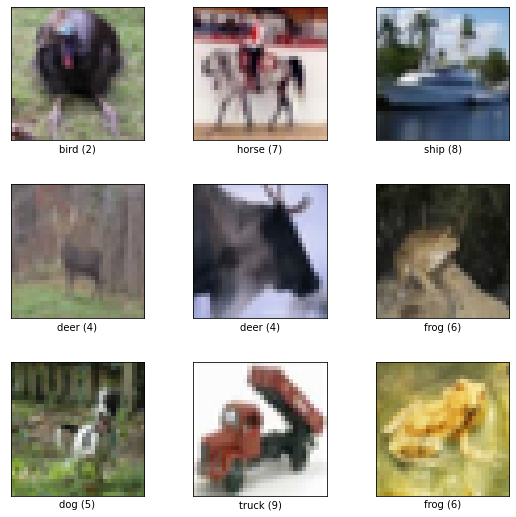

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

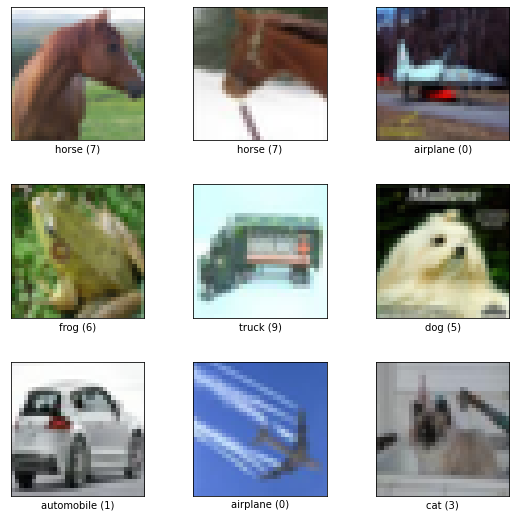

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

## 2.1 VGG 모델구성
 - 모델 구성에 있어 VGG 16, 19는 기본 노드에 있는 코드 그대로 가져와서 사용을 하였고, 
 - VGG 34, 50은 Resnet을 먼저 구성을 하고 Resnset 블럭에서 shortcut connection을 주석처리하여 Plain Network로서 구성을 하였다. 
 - 함수 구현에 있어 좀 더 짧고 쉽게 구현할 수 있겠지만 논문자료의 Structure 비교를 위해 순차적으로 나열하는 방식으로 구현하였다.
 - Identity mapping은 shortcut으로 표현하여 구현하였다.
 ![Resnet Block]("https://user-images.githubusercontent.com/38655888/114557482-add63b80-9ca4-11eb-8d51-9c6ead60901b.png")
 
 - 아래 그림에서 VGG(Plain)34 network를 구성하고 Resnet-34를 구성하여 비교할 수 있도록 구성하였다." 
 - 이전 연구에서 제안되었던 VGG-19를 기본으로 34, 50 lalyer의 Plain Network를 구성하였다
 - Resnet은 3x3 conv 2개 마다 반복하는데 Residual 함수인 shortcut을 사용하였고 점선부분은 입력과 출력의 사이즈 차이로 맞춰줄 수 있는 테크닉을 추가하였다.
   
 ![Resnet Block]("https://user-images.githubusercontent.com/38655888/114557484-add63b80-9ca4-11eb-96f5-2c5b5b39c4e5.jpeg")

 
#### VGG Block 구성하기

In [ ]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [ ]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [ ]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


### VGG-16

In [ ]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### VGG-19

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### VGG-34

In [ ]:
# VGG plain 34
# number of classes
K = 10
#input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')

def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x    
 
# 각 stage마다 첫번째 block은 이전 stage에서 받아온 텐서의 dimension을 증가시켜야 하기 때문에(뒤에서 add연산 하기 위해) if문으로 처리하였다.
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
    #shortcut = x
 
    for i in range(3):
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)            
            #x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
            #shortcut = x            
    return x
 
def conv3_layer(x):  
    #shortcut = x    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            #shortcut = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(shortcut) #확인 필요
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)            
            #x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
            #shortcut = x              
        else:
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            #x = Add()([x, shortcut])     
            #x = Activation('relu')(x)
            #shortcut = x      
    return x
 
def conv4_layer(x):
    #shortcut = x        
    for i in range(6):     
        if(i == 0):                        
            x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            #shortcut = Conv2D(256, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)
            #x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
            #shortcut = x               
        else:
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            #x = Add()([x, shortcut])    
            #x = Activation('relu')(x)
            #shortcut = x      
    return x
 
def conv5_layer(x):
    #shortcut = x    
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            #shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)            
            #x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
            #shortcut = x               
        else:
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)           
            #x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
            #shortcut = x                  
    return x
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)

vgg_34 = Model(input_tensor, output_tensor)
vgg_34.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 38, 38, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 64)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 18, 18, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0   

### VGG-50

In [ ]:
# VGG 50
# number of classes
K = 10
 
#input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')

def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   

def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
    #shortcut = x
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            #shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)
 
            #x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            #x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
            #shortcut = x        
    return x
 
def conv3_layer(x):        
    #shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            #shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)            
 
            #x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            #shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            #x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            #shortcut = x      
    return x
 
def conv4_layer(x):
    #shortcut = x        
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            #shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)
 
            #x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            #shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            #x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            #shortcut = x      
    return x
 
def conv5_layer(x):
    #shortcut = x    
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            #shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)            
 
            #x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            #x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            #shortcut = x                  
 
    return x
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)
 
vgg_50 = Model(input_tensor, output_tensor)
vgg_50.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 38, 38, 3)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_33 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_33 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 18, 18, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0   

## 2.2 Resnet 모델구성
### Resnet-34

In [ ]:
# Resnet 34
# Add Skip Connection(shorcut) 
# number of classes
K = 10
 
#input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')

def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    return x    
 
# 각 stage마다 첫번째 block은 이전 stage에서 받아온 텐서의 dimension을 증가시켜야 하기 때문에(뒤에서 add연산 하기 위해) if문으로 처리하였다.
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
    shortcut = x
    for i in range(3):
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    return x
 
def conv3_layer(x):     
    shortcut = x    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(shortcut) #확인 필요
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            #x = Activation('relu')(x)
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
def conv4_layer(x):
    shortcut = x        
    for i in range(6):     
        if(i == 0):                        
            x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(256, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            #x = Activation('relu')(x)
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
    return x
 
def conv5_layer(x):

    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        

            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)
 
resnet_34 = Model(input_tensor, output_tensor)
resnet_34.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 38, 38, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 16, 16, 64)   9472        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
batch_normalization_82 (BatchNo (None, 16, 16, 64)   256         conv2d_82[0][0]                  
____________________________________________________________________________________________

### Resnet-50

In [6]:
# Resnet 50
# number of classes
K = 10
 
#input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')

def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
    shortcut = x
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)
 
resnet_50 = Model(input_tensor, output_tensor)
resnet_50.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 38, 38, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 16, 16, 64)   9472        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
batch_normalization_108 (BatchN (None, 16, 16, 64)   256         conv2d_108[0][0]                 
_______________________________________________________________________________________

## 2.3 모델학습
### VGG-16 , VGG-19, VGG-34, VGG-50, Resnet-34, Resnet-50

In [ ]:
BATCH_SIZE = 256
EPOCH = 50

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
195/195 [==============================] - 55s 185ms/step - loss: 2.2471 - accuracy: 0.1598 - val_loss: 2.0932 - val_accuracy: 0.2435
Epoch 2/50
195/195 [==============================] - 16s 80ms/step - loss: 2.0402 - accuracy: 0.2560 - val_loss: 1.9251 - val_accuracy: 0.3245
Epoch 3/50
195/195 [==============================] - 16s 80ms/step - loss: 1.9109 - accuracy: 0.3083 - val_loss: 1.7908 - val_accuracy: 0.3746
Epoch 4/50
195/195 [==============================] - 16s 81ms/step - loss: 1.7809 - accuracy: 0.3623 - val_loss: 1.7221 - val_accuracy: 0.3824
Epoch 5/50
195/195 [==============================] - 16s 80ms/step - loss: 1.6915 - accuracy: 0.3914 - val_loss: 1.6265 - val_accuracy: 0.4128
Epoch 6/50
195/195 [==============================] - 16s 81ms/step - loss: 1.6245 - accuracy: 0.4130 - val_loss: 1.5613 - val_accuracy: 0.4474
Epoch 7/50
195/195 [==============================] - 16s 81ms/step - loss: 1.5577 - accuracy: 0.4408 - val_loss: 1.5219 - val_accuracy

In [ ]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
195/195 [==============================] - 21s 95ms/step - loss: 2.2814 - accuracy: 0.1375 - val_loss: 2.1450 - val_accuracy: 0.1935
Epoch 2/50
195/195 [==============================] - 18s 95ms/step - loss: 2.0917 - accuracy: 0.2296 - val_loss: 1.9668 - val_accuracy: 0.2552
Epoch 3/50
195/195 [==============================] - 18s 95ms/step - loss: 1.9363 - accuracy: 0.2974 - val_loss: 1.8132 - val_accuracy: 0.3382
Epoch 4/50
195/195 [==============================] - 18s 94ms/step - loss: 1.7922 - accuracy: 0.3532 - val_loss: 1.7043 - val_accuracy: 0.3755
Epoch 5/50
195/195 [==============================] - 18s 95ms/step - loss: 1.6957 - accuracy: 0.3932 - val_loss: 1.6419 - val_accuracy: 0.4129
Epoch 6/50
195/195 [==============================] - 18s 95ms/step - loss: 1.6380 - accuracy: 0.4104 - val_loss: 1.5792 - val_accuracy: 0.4279
Epoch 7/50
195/195 [==============================] - 18s 95ms/step - loss: 1.5697 - accuracy: 0.4302 - val_loss: 1.5651 - val_accuracy:

In [ ]:
vgg_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_vgg_34 = vgg_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,)

Epoch 1/50
195/195 [==============================] - 42s 136ms/step - loss: 2.4743 - accuracy: 0.1106 - val_loss: 2.3081 - val_accuracy: 0.0944
Epoch 2/50
195/195 [==============================] - 11s 58ms/step - loss: 2.3047 - accuracy: 0.1332 - val_loss: 2.4223 - val_accuracy: 0.0941
Epoch 3/50
195/195 [==============================] - 11s 59ms/step - loss: 2.1962 - accuracy: 0.1691 - val_loss: 2.1400 - val_accuracy: 0.2013
Epoch 4/50
195/195 [==============================] - 12s 59ms/step - loss: 2.0220 - accuracy: 0.2301 - val_loss: 2.2088 - val_accuracy: 0.2295
Epoch 5/50
195/195 [==============================] - 12s 59ms/step - loss: 1.8566 - accuracy: 0.2969 - val_loss: 1.9573 - val_accuracy: 0.2862
Epoch 6/50
195/195 [==============================] - 12s 59ms/step - loss: 1.7198 - accuracy: 0.3547 - val_loss: 1.7665 - val_accuracy: 0.3424
Epoch 7/50
195/195 [==============================] - 12s 59ms/step - loss: 1.5922 - accuracy: 0.4044 - val_loss: 2.5340 - val_accuracy

In [ ]:
vgg_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_vgg_50 = vgg_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,)

Epoch 1/50
195/195 [==============================] - 40s 98ms/step - loss: 2.4843 - accuracy: 0.1074 - val_loss: 2.3241 - val_accuracy: 0.0998
Epoch 2/50
195/195 [==============================] - 13s 66ms/step - loss: 2.3831 - accuracy: 0.1111 - val_loss: 2.3549 - val_accuracy: 0.1033
Epoch 3/50
195/195 [==============================] - 27s 140ms/step - loss: 2.3516 - accuracy: 0.1119 - val_loss: 3.0084 - val_accuracy: 0.1268
Epoch 4/50
195/195 [==============================] - 13s 66ms/step - loss: 2.3224 - accuracy: 0.1195 - val_loss: 2.8507 - val_accuracy: 0.1311
Epoch 5/50
195/195 [==============================] - 13s 66ms/step - loss: 2.3040 - accuracy: 0.1267 - val_loss: 2.4061 - val_accuracy: 0.1337
Epoch 6/50
195/195 [==============================] - 13s 66ms/step - loss: 2.2931 - accuracy: 0.1282 - val_loss: 2.5837 - val_accuracy: 0.1301
Epoch 7/50
195/195 [==============================] - 13s 66ms/step - loss: 2.2804 - accuracy: 0.1320 - val_loss: 2.4304 - val_accuracy

In [ ]:
BATCH_SIZE = 256
EPOCH = 50

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,)

Epoch 1/20
195/195 [==============================] - 25s 83ms/step - loss: 2.6295 - accuracy: 0.2144 - val_loss: 2.4636 - val_accuracy: 0.1098
Epoch 2/20
195/195 [==============================] - 12s 61ms/step - loss: 1.7327 - accuracy: 0.3884 - val_loss: 2.4871 - val_accuracy: 0.1588
Epoch 3/20
195/195 [==============================] - 12s 61ms/step - loss: 1.4889 - accuracy: 0.4678 - val_loss: 1.6155 - val_accuracy: 0.4176
Epoch 4/20
195/195 [==============================] - 12s 62ms/step - loss: 1.3017 - accuracy: 0.5375 - val_loss: 1.5362 - val_accuracy: 0.4568
Epoch 5/20
195/195 [==============================] - 12s 61ms/step - loss: 1.1369 - accuracy: 0.5973 - val_loss: 1.6591 - val_accuracy: 0.4464
Epoch 6/20
195/195 [==============================] - 12s 62ms/step - loss: 1.0077 - accuracy: 0.6476 - val_loss: 1.5761 - val_accuracy: 0.4815
Epoch 7/20
195/195 [==============================] - 12s 62ms/step - loss: 0.8155 - accuracy: 0.7201 - val_loss: 1.6285 - val_accuracy:

In [ ]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,)

Epoch 1/20
195/195 [==============================] - 30s 103ms/step - loss: 3.0503 - accuracy: 0.1240 - val_loss: 2.4525 - val_accuracy: 0.0930
Epoch 2/20
195/195 [==============================] - 17s 85ms/step - loss: 2.4731 - accuracy: 0.1731 - val_loss: 2.6692 - val_accuracy: 0.1100
Epoch 3/20
195/195 [==============================] - 18s 90ms/step - loss: 2.2809 - accuracy: 0.2062 - val_loss: 2.3245 - val_accuracy: 0.1831
Epoch 4/20
195/195 [==============================] - 17s 85ms/step - loss: 2.1708 - accuracy: 0.2355 - val_loss: 2.4350 - val_accuracy: 0.2108
Epoch 5/20
195/195 [==============================] - 17s 85ms/step - loss: 2.0539 - accuracy: 0.2644 - val_loss: 2.5567 - val_accuracy: 0.2121
Epoch 6/20
195/195 [==============================] - 17s 85ms/step - loss: 1.9537 - accuracy: 0.2994 - val_loss: 3.1915 - val_accuracy: 0.2390
Epoch 7/20
195/195 [==============================] - 17s 85ms/step - loss: 1.8539 - accuracy: 0.3349 - val_loss: 2.6680 - val_accuracy

## 2.4 모델 성능결과 확인

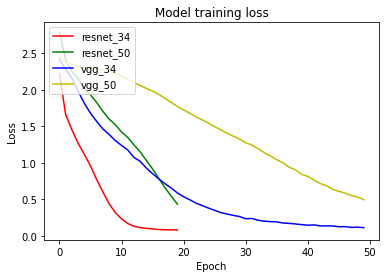

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'g')
plt.plot(history_vgg_34.history['loss'], 'b')
plt.plot(history_vgg_50.history['loss'], 'y')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'vgg_34','vgg_50'], loc='upper left')
plt.show()

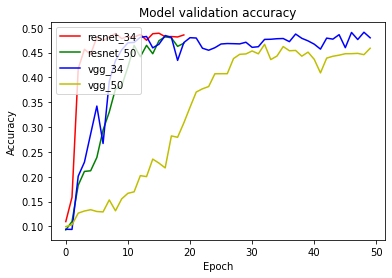

In [ ]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'g')
plt.plot(history_vgg_34.history['val_accuracy'], 'b')
plt.plot(history_vgg_50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'vgg_34','vgg_50'], loc='upper left')
plt.show()

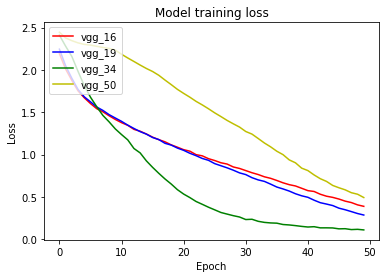

In [ ]:
plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.plot(history_vgg_34.history['loss'], 'g')
plt.plot(history_vgg_50.history['loss'], 'y')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19', 'vgg_34', 'vgg_50'], loc='upper left')
plt.show()

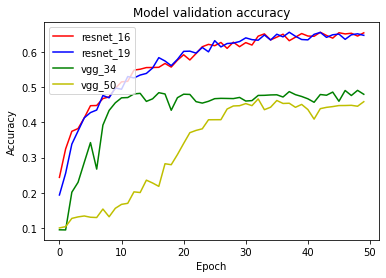

In [ ]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.plot(history_vgg_34.history['val_accuracy'], 'g')
plt.plot(history_vgg_50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_16', 'resnet_19', 'vgg_34','vgg_50'], loc='upper left')
plt.show()

### CIFAR-10 Dataset 모델 학습 결과 정리
 1. 가장 먼저 VGG Network 를 16, 19, 34, 50 레이어로 쌓아감에 따라 Loss가 예상과 반대로 올라감을 확인할 수 있다.
 - 이는 처음 서두에 Resnet 논문의 문제인식 부분에서 언급한대로 Degration Problem 문제임을 확인할 수 있다.
 2. 이를 해결하기 위해 Resnet을 사용하였고 초기 학습 성능과 Accuracy 모두 좋은 성능을 보임을 확인할 수 있다.
 - 하지만 노드에서 언급한대로 데이터의 사이즈와 모델의 깊이에 차이가 있어 제대로 된 성능비교가 어려움을 확인하였다.

#### 데이터 변경
Resnet은 많은 레이어와 pooling을 거치므로 CIFAR-10에서는 오버피팅으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야할 변수(parameter)가 많은 데 비해, 데이터수가 많지 않기 때문입니다. 224*224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 

## 3. Cat & Dogs Dataset

In [ ]:
#dataset_name = 'cats_vs_dogs'

#ds_train_cat_dog = tfds.load('cats_vs_dogs', split='train[:80%]')
#ds_test_cat_dog = tfds.load('cats_vs_dogs', split='train[80%:]')

(ds_train_cat_dog, ds_test_cat_dog), ds_info_cat_dog = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [ ]:
print(ds_info_cat_dog.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [ ]:
print(tf.data.experimental.cardinality(ds_train_cat_dog))
print(tf.data.experimental.cardinality(ds_test_cat_dog))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [ ]:
ds_info_cat_dog.features["label"].num_classes

2

In [ ]:
ds_info_cat_dog.features["label"].names

['cat', 'dog']

In [ ]:
fig = tfds.show_examples(ds_train_cat_dog, ds_info_cat_dog)

In [ ]:
# 2) Input Normalization
def normalize_and_resize_img_cat_dog(data):
    """Normalizes images: `uint8` -> `float32`."""
    
    #image = tf.image.resize(image, [224, 224])
    x = data['image']
    y = data['label']
    x = tf.image.resize(x, size=(224,224)) # size 변경 
    x = tf.cast(x, tf.float32) / 255. # size 변경 
    return x, y
def apply_normalize_on_dataset_cat_dog(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img_cat_dog, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
BATCH_SIZE = 16
EPOCH = 50

In [ ]:
ds_train_cat_dog = apply_normalize_on_dataset_cat_dog(ds_train_cat_dog, batch_size=BATCH_SIZE)
ds_test_cat_dog = apply_normalize_on_dataset_cat_dog(ds_test_cat_dog, batch_size=BATCH_SIZE)
#ds_train_cat_dog = ds_train_cat_dog.map(normalize_and_resize_img).batch(BATCH_SIZE)

## 3.1 Resnet
### Resnet-34

In [5]:
# Resnet 34
# Add Skip Connection(shorcut) 
# number of classes
K = 2
 
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
#input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')

 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x    
 
    
# 각 stage마다 첫번째 block은 이전 stage에서 받아온 텐서의 dimension을 증가시켜야 하기 때문에(뒤에서 add연산 하기 위해) if문으로 처리하였다.
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
    shortcut = x
 
    for i in range(3):
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
def conv3_layer(x):  
      
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(shortcut) #확인 필요
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            #x = Activation('relu')(x)
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):

    shortcut = x        
  
    for i in range(6):     
        if(i == 0):                        
            x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(256, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            #x = Activation('relu')(x)
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):

    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            

            x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        

            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
#x = keras.layers.Flatten(name='flatten')(x)
output_tensor = Dense(K, activation='softmax')(x)
 
resnet_34_cat_dog = Model(input_tensor, output_tensor)
resnet_34_cat_dog.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 112, 112, 64) 9472        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 112, 112, 64) 256         conv2d_72[0][0]                  
_______________________________________________________________________________________

### Resnet-50

In [7]:
# Resnet 50

# number of classes
K = 2
 
 
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
#input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')

 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
    
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)

x = GlobalAveragePooling2D()(x)
#x = Flatten(name='flatten')(x)
output_tensor = Dense(K, activation='softmax')(x)
 
resnet_50_cat_dog = Model(input_tensor, output_tensor)
resnet_50_cat_dog.summary()



Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 230, 230, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_161 (Conv2D)             (None, 112, 112, 64) 9472        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
batch_normalization_161 (BatchN (None, 112, 112, 64) 256         conv2d_161[0][0]                 
_______________________________________________________________________________________

## 3.2 VGG (Plain Network)
### VGG-34 (plain network)

In [ ]:
# VGG plain 34

# number of classes
K = 2
 
 
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
#input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')

 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x    
 
    
# 각 stage마다 첫번째 block은 이전 stage에서 받아온 텐서의 dimension을 증가시켜야 하기 때문에(뒤에서 add연산 하기 위해) if문으로 처리하였다.
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
    #shortcut = x
 
    for i in range(3):
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)            
 
            #x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            #shortcut = x        
    
    return x
 
def conv3_layer(x):  
      
    #shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            #shortcut = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(shortcut) #확인 필요
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)            
 
            #x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            #shortcut = x              
        
        else:
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            #x = Add()([x, shortcut])     
            #x = Activation('relu')(x)
 
            #shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):

    #shortcut = x        
  
    for i in range(6):     
        if(i == 0):                        
            x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            #shortcut = Conv2D(256, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)
 
            #x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            #shortcut = x               
        
        else:
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            #x = Add()([x, shortcut])    
            #x = Activation('relu')(x)
 
            #shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):

    #shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            

            x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        

            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            #shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)            
 
            #x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            #shortcut = x               
        
        else:
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)           
            
            #x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            #shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)
 
vgg_34_cat_dog = Model(input_tensor, output_tensor)
vgg_34_cat_dog.summary()


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_24 (ZeroPaddi (None, 230, 230, 3)       0         
_________________________________________________________________
conv2d_520 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_520 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_492 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_25 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 56, 56, 64)        0  

### VGG-50

In [ ]:
# VGG 50
# number of classes
K = 2
 
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
#input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')

def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    return x   
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
    #shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            #shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)
 
            #x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            #x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            #shortcut = x        
    
    return x
 
def conv3_layer(x):        
    #shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            #shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)            
 
            #x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            #shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            #x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            #shortcut = x      
            
    return x
 
def conv4_layer(x):
    #shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            #shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)
 
            #x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            #shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            #x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            #shortcut = x      
 
    return x
 
def conv5_layer(x):
    #shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            #shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            #shortcut = BatchNormalization()(shortcut)            
 
            #x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            #x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            #shortcut = x                  

    return x
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)
 
vgg_50_cat_dog = Model(input_tensor, output_tensor)
vgg_50_cat_dog.summary()


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_26 (ZeroPaddi (None, 230, 230, 3)       0         
_________________________________________________________________
conv2d_553 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_553 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_525 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 64)        0  

## 3.3 모델 학습

In [ ]:
resnet_34_cat_dog.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34_cat_dog = resnet_34_cat_dog.fit(
    ds_train_cat_dog,
    steps_per_epoch=int(ds_info_cat_dog.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_cat_dog.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_cat_dog,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
1163/1163 [==============================] - 130s 89ms/step - loss: 0.6808 - accuracy: 0.5960 - val_loss: 0.6399 - val_accuracy: 0.6431
Epoch 2/50
1163/1163 [==============================] - 111s 95ms/step - loss: 0.6031 - accuracy: 0.6698 - val_loss: 0.9158 - val_accuracy: 0.5587
Epoch 3/50
1163/1163 [==============================] - 102s 88ms/step - loss: 0.5447 - accuracy: 0.7256 - val_loss: 0.7018 - val_accuracy: 0.6411
Epoch 4/50
1163/1163 [==============================] - 102s 88ms/step - loss: 0.4781 - accuracy: 0.7767 - val_loss: 0.4596 - val_accuracy: 0.7849
Epoch 5/50
1163/1163 [==============================] - 102s 88ms/step - loss: 0.4094 - accuracy: 0.8137 - val_loss: 1.5031 - val_accuracy: 0.5638
Epoch 6/50
1163/1163 [==============================] - 102s 88ms/step - loss: 0.3380 - accuracy: 0.8528 - val_loss: 0.5682 - val_accuracy: 0.7634
Epoch 7/50
1163/1163 [==============================] - 103s 88ms/step - loss: 0.2688 - accuracy: 0.8855 - val_loss: 0

In [ ]:
resnet_50_cat_dog.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50_cat_dog = resnet_50_cat_dog.fit(
    ds_train_cat_dog,
    steps_per_epoch=int(ds_info_cat_dog.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_cat_dog.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_cat_dog,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
1163/1163 [==============================] - 281s 207ms/step - loss: 0.7362 - accuracy: 0.5503 - val_loss: 1.3922 - val_accuracy: 0.5218
Epoch 2/50
1163/1163 [==============================] - 187s 160ms/step - loss: 0.6932 - accuracy: 0.6012 - val_loss: 0.9948 - val_accuracy: 0.5250
Epoch 3/50
1163/1163 [==============================] - 197s 169ms/step - loss: 0.6788 - accuracy: 0.6023 - val_loss: 0.6862 - val_accuracy: 0.5839
Epoch 4/50
1163/1163 [==============================] - 196s 169ms/step - loss: 0.6726 - accuracy: 0.6138 - val_loss: 0.7637 - val_accuracy: 0.5600
Epoch 5/50
1163/1163 [==============================] - 203s 175ms/step - loss: 0.6556 - accuracy: 0.6337 - val_loss: 0.7105 - val_accuracy: 0.6066
Epoch 6/50
1163/1163 [==============================] - 199s 171ms/step - loss: 0.6427 - accuracy: 0.6471 - val_loss: 0.6535 - val_accuracy: 0.6516
Epoch 7/50
1163/1163 [==============================] - 209s 179ms/step - loss: 0.6340 - accuracy: 0.6593 - val_

In [ ]:
vgg_34_cat_dog.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_vgg_34_cat_dog = vgg_34_cat_dog.fit(
    ds_train_cat_dog,
    steps_per_epoch=int(ds_info_cat_dog.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_cat_dog.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_cat_dog,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
1163/1163 [==============================] - 113s 92ms/step - loss: 0.7010 - accuracy: 0.5306 - val_loss: 0.7143 - val_accuracy: 0.5034
Epoch 2/50
1163/1163 [==============================] - 109s 94ms/step - loss: 0.6915 - accuracy: 0.5452 - val_loss: 0.7988 - val_accuracy: 0.5228
Epoch 3/50
1163/1163 [==============================] - 104s 89ms/step - loss: 0.6782 - accuracy: 0.5736 - val_loss: 0.8799 - val_accuracy: 0.5328
Epoch 4/50
1163/1163 [==============================] - 104s 90ms/step - loss: 0.6722 - accuracy: 0.5904 - val_loss: 0.7072 - val_accuracy: 0.5677
Epoch 5/50
1163/1163 [==============================] - 109s 93ms/step - loss: 0.6550 - accuracy: 0.6112 - val_loss: 0.6667 - val_accuracy: 0.6107
Epoch 6/50
1163/1163 [==============================] - 105s 90ms/step - loss: 0.6414 - accuracy: 0.6342 - val_loss: 0.6415 - val_accuracy: 0.6468
Epoch 7/50
1163/1163 [==============================] - 107s 92ms/step - loss: 0.6270 - accuracy: 0.6516 - val_loss: 0

In [ ]:
vgg_50_cat_dog.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_vgg_50_cat_dog = vgg_50_cat_dog.fit(
    ds_train_cat_dog,
    steps_per_epoch=int(ds_info_cat_dog.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_cat_dog.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_cat_dog,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
1163/1163 [==============================] - 149s 121ms/step - loss: 0.7104 - accuracy: 0.5383 - val_loss: 0.8298 - val_accuracy: 0.5108
Epoch 2/50
1163/1163 [==============================] - 139s 120ms/step - loss: 0.7112 - accuracy: 0.5311 - val_loss: 1.7755 - val_accuracy: 0.5019
Epoch 3/50
1163/1163 [==============================] - 139s 120ms/step - loss: 0.7156 - accuracy: 0.4985 - val_loss: 0.8034 - val_accuracy: 0.5054
Epoch 4/50
1163/1163 [==============================] - 139s 120ms/step - loss: 0.7094 - accuracy: 0.5086 - val_loss: 1.2048 - val_accuracy: 0.4933
Epoch 5/50
1163/1163 [==============================] - 139s 120ms/step - loss: 0.7063 - accuracy: 0.5314 - val_loss: 0.8634 - val_accuracy: 0.4815
Epoch 6/50
1163/1163 [==============================] - 139s 120ms/step - loss: 0.7049 - accuracy: 0.5303 - val_loss: 0.8240 - val_accuracy: 0.5181
Epoch 7/50
1163/1163 [==============================] - 139s 120ms/step - loss: 0.7060 - accuracy: 0.5229 - val_

## 3.4 모델 성능 결과

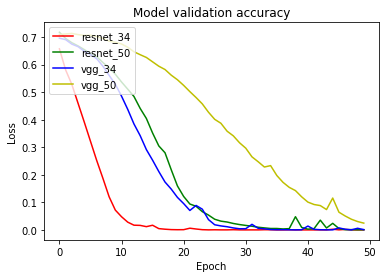

In [ ]:
plt.plot(history_resnet_34_cat_dog.history['loss'], 'r')
plt.plot(history_resnet_50_cat_dog.history['loss'], 'g')
plt.plot(history_vgg_34_cat_dog.history['loss'], 'b')
plt.plot(history_vgg_50_cat_dog.history['loss'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'vgg_34','vgg_50'], loc='upper left')
plt.show()

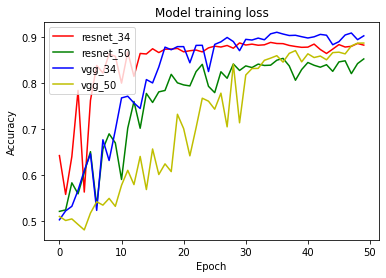

In [ ]:
plt.plot(history_resnet_34_cat_dog.history['val_accuracy'], 'r')
plt.plot(history_resnet_50_cat_dog.history['val_accuracy'], 'g')
plt.plot(history_vgg_34_cat_dog.history['val_accuracy'], 'b')
plt.plot(history_vgg_50_cat_dog.history['val_accuracy'], 'y')
plt.title('Model training loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'vgg_34','vgg_50'], loc='upper left')
plt.show()

# 4. 정리
  - 2.4절 CIFAR-10데이터로 성능을 확인한 VGG-16, 19, 34, 50에서 Degration Problem 을 확인하였다. 
    * Vanishing 은 sigmoid 같은 활성함수 사용하면 역전파 과정에서 기울기가 0에 가까워져서 학습이 안되는경우
    * Overfit 같은 경우도 레이어가 깊어질때 생기는 문제
    * 여기서 Resnet의 문제는 vanishing / overfit 문제가 아닌 Degration Problem 임을 다시 강조한다.
  
  - Resnet 논문에서 문제제기하였던 레이어가 쌓여감에 따라 발생되는 문제를 직접 모델을 구현하여 학습을 하고 성능을 통해 검증하였다.
  - 논문에서는 Plain network에서 forward, backward 방향에서 Vanishing 문제는 거의 발생하지 않았다고 하였지만 이를 확인할 수는 없었고 
    추후 코드를 통해 검증할 수 있는 방법을 고민해볼 필요가 있다.
  - 3절에서 논문과 동일한 224X224X3 픽셀크기의 데이터셋을 통해 학습을 하였고 Epoch 50 결과를 위 그래프와 같이 나타내었다.
  - VGG는 레이어가 깊어질수록 성능이 안좋아지고, Resnet은 레이어가 깊어질수록 성능이 좋아졌다. 
  - 이 문제는 Vanishing gradient문제는 없었다고 한다. 논문 저자는 이러한 문제는 exponentially low convergence rates 라고 확인하고 있다. 수렴율이 기하급수록적으로 낮아지는게 문제이며 추측하기로 수렴율이 낮아지기 때문이라고 생각하고 있다. 
  - VGG 네트워크에 비해 더욱 적은 파라미터를 사용하고 복잡도도 작았다. 그럼에도 더 높은 성능을 확인할 수 있다.
  - 초기단계에서 더 빠르게 수렴할 수 있는것이 장점이고 VGG비해 더 적은 파라미터와 복잡도로 성능을 높일수있다.


## 루브릭
1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?
 - 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.
2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?
 - cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.
3. Ablation Study 결과가 바른 포맷으로 제출되었는가?
 - ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.